In [1]:
import ROOT
ROOT.gStyle.SetPalette(61)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetTextFont(42)
ROOT.gStyle.SetTextSize(0.05)
ROOT.gStyle.SetPadTickY(1)

import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

sys.path.append("/eos/home-y/yabulait/wjets/")
sys.path.append("/eos/home-y/yabulait/wjets/time-odd-asymmetry")
from context import (Luminosity_fb, Luminosity_pb, grid_date, leptons,mc_processes, samples)

import pyrootUtil
import json
from wjetsAsymmetryFrame import *

import pyrootUtil.plotUtil.styles as styles

def get_rdf(filePath,
            branches=["weight_mc", "deta_lj", "Xperp","nbjet", "mT", "qT", "met", "signalMu_pt", "signalMu_charge"]):
    wjets = wjetsAsymmetryFrame()
    try:
        df_preSelected = wjets.load_raw_data(tree_name="nominal", files=[filePath], branches=branches)
    except Exception as inst:
        return None, None
    else:
        dsid = filePath.split('/')[-1]
        dsid = dsid.split('.')[0]
        return  df_preSelected, dsid



def fill_histogram(RDFs, hist, var, weightBR=None):
    histoDic = {}
    for dsid, _df in RDFs.items():
        if weightBR:
            histoDic[dsid] = _df.Histo1D(hist, var, weightBR)
        else:
            histoDic[dsid] = _df.Histo1D(hist, var)
    return histoDic

    
def NormalizeHist(histDic, weightsDic):
    for _id in histDic.keys():
        _weight = Luminosity_pb*weightsDic[_id][1]/weightsDic[_id][0]
        histDic[_id].Scale(_weight)
    return histDic

def groupBy(histDic, processes):
    #processes--> {"wjets": [ids]}
    _hDic={}
    keys = histDic.keys()
    for process, ids in processes.items():
        #print ("process, ids = ", process, ids)
        _hist = None
        for _id in keys:
            if _id not in ids: continue
            if _hist is None:
                _hist = histDic[_id].Clone()
            else:
                _hist.Add(histDic[_id].Clone())
        
        _hDic[process] = _hist
    return _hDic

def draw_atlas_label(x=0.57, y=0.85, label="Internal" ):
    AL = ROOT.TLatex() #l.SetTextAlign(12) l.SetTextSize(tsize)
    AL.SetNDC()
    AL.SetTextFont(72)
    AL.SetTextColor(ROOT.kBlack)
    Inetrnal = ROOT.TLatex()
    Inetrnal.SetNDC()
    Inetrnal.SetTextFont(42)
    Inetrnal.SetTextColor(ROOT.kBlack)
    ## print text
    TL = ROOT.TLatex()
    TL.SetNDC(1)
    AL.DrawLatex(x,y,"ATLAS")
    Inetrnal.DrawLatex(x+0.12,y,label)
    styles.energy_lumi(x,y-0.06,13, Luminosity_fb)

def createColorTable(size=1, color_map=61):
    ROOT.gStyle.SetPalette(color_map)
    _step = int(color_map/size)   
    return [ROOT.TColor.GetColorPalette(i*_step) for i in range(0,size)]

sample_colors = createColorTable(size=3, color_map=61)
cwjets, cttbar, cWWlpqq = 0,1,2

def plot_samples(hVarDic, log=None, x_label=None, y_label=None):
    if x_label:
        hVarDic["Wmunu"].GetXaxis().SetTitle(x_label)
    if y_label:
        hVarDic["Wmunu"].GetYaxis().SetTitle(y_label)
        
    hLabels = list(hVarDic.keys())
    hLists = [hVarDic[key] for key in hLabels]
    canv = fig.plot(hLists,
                hLabels, option="same e0",
                color=sample_colors)
    fig.legend(x=[0.65,0.89], y=[0.73,0.89])
    if log: fig.log(log)
    canv.Draw()


def plot_samples_stack(hVarDic, log=None, x_label=None, y_label=None, Draw_option="HIST SAME PFC PLC"):
    if x_label:
        hVarDic["Wmunu"].GetXaxis().SetTitle(x_label)
    if y_label:
        hVarDic["Wmunu"].GetYaxis().SetTitle(y_label)
        
    hLabels = list(hVarDic.keys())
    hLists = [hVarDic[key] for key in hLabels]
    canv = fig.stack(hLists, hLabels,
                color=createColorTable(size=len(hLabels), color_map=61), option=Draw_option)
    
    fig.legend(x=[0.65,0.89], y=[0.73,0.89])
    if log: fig.log(log)
    canv.Draw()
    canv.RedrawAxis()
    return canv

Welcome to JupyROOT 6.20/06


In [2]:
event_weights = None
with open("../data/{}/sample_weights.txt".format(grid_date),"r") as f:
    event_weights= json.load( f)
    
process_groups = {"Wenu": ["364170",  "364172",  "364174",  "364176",  "364178",  "364180",
                            "364182",  "364171",  "364173",  "364175",  "364177",  "364179",
                            "364181",  "364183"],
                  "Wmunu" : ["364156", "364157", "364158", "364159", "364160", "364161",
                            "364162", "364163", "364164", "364165", "364166", "364167",
                            "364168", "364169"],
                  "Wtaunu": ["364184", "364185", "364186", "364187", "364188", "364189", "364190",
                            "364191", "364192", "364193", "364194", "364195", "364196", "364197"],
                  "ttbar": ["410470"],
                  "WWlpqq": ["363360", "363361"],
                  "singleTop": ["410646", "410647", "410658", "410659"],
                  "Ztautau": ["364128", "364129", "364130", "364131","364132", "364133",
                             "364134", "364135", "364136", "364137", "364138", "364139",
                             "364140", "364141"],
                  "Zmumu": ["364100", "364101", "364102", "364103", "364104", "364105",
                           "364106", "364107", "364108", "364109", "364110", "364111",
                           "364112", "364113"]
                 }

datatype="mc16"
datasetsRDF_mc16={}

input_dir = "/eos/home-y/yabulait/wjets/ntuples/{0}/{1}/tight_selection/mu/".format(datatype,grid_date)
for dataset in [input_dir+f for f in os.listdir(input_dir)]:
    _df, _dsid = get_rdf(dataset,
                        branches=["weight_mc", "weight_pileup", "deta_lj", "Xperp","nbjet", 
                                  "mT", "qT", "met", "signalMu_pt", "signalMu_charge", "mu",
                                 "weight_leptonSF", "weight_bTagSF_DL1r_77","weight_jvt"])
    if _df is None: continue
    try:
        _df = _df.Filter("signalMu_charge[0]>0&&signalMu_pt[0]>30000&&(nbjet<1)&&met>30000&&qT>30000")\
                 .Define("weight_total", "weight_mc*weight_pileup*weight_leptonSF*weight_bTagSF_DL1r_77*weight_jvt")\
                  .Define("mT_GeV", "mT*0.001")
    except:
        print("empty file: ", _dsid)
    else:
        datasetsRDF_mc16[_dsid]= _df



empty file:  364170
empty file:  364179


Error in <TChain::LoadTree>: Cannot find tree with name nominal in file /eos/home-y/yabulait/wjets/ntuples/mc16/20200624_1530/tight_selection/mu/364170.root
Error in <TChain::LoadTree>: Cannot find tree with name nominal in file /eos/home-y/yabulait/wjets/ntuples/mc16/20200624_1530/tight_selection/mu/364179.root


In [3]:
h_mT_mc16 = fill_histogram(datasetsRDF_mc16,("mt", "mT",30, 0,300), "mT_GeV", weightBR="weight_total")
h_Xprep_mc16 = fill_histogram(datasetsRDF_mc16,("Xperp","Xperp",100,-3.5,3.5), "Xperp", weightBR="weight_total")

h_mT_mc16_grouped_by_processes = groupBy(NormalizeHist(h_mT_mc16,event_weights), process_groups)
h_Xprep_mc16_grouped_by_processes = groupBy(NormalizeHist(h_Xprep_mc16,event_weights), process_groups)

In [4]:
#datatype="mc16"
datasetsRDF_data16={}
data_dir = "/eos/home-y/yabulait/wjets/ntuples/data16/{0}/tight_selection/mu/".format(grid_date)

data_groups = {"data16" : [_f.strip(".root") for _f in os.listdir(data_dir)] }

for dataset in [data_dir+f for f in os.listdir(data_dir)]:
    _df, _dsid = get_rdf(dataset, 
                         branches=["deta_lj", "Xperp","nbjet", "mT", "qT", 
                                   "met", "signalMu_pt", "signalMu_charge", "mu"])
    if _df is None: continue
    try:
        _df = _df.Filter("signalMu_charge[0]>0&&signalMu_pt[0]>30000&&(nbjet<1)&&met>30000&&qT>30000").Define("mT_GeV", "mT*0.001")
    except:
        print("empty file: ", _dsid)
    else:
        datasetsRDF_data16[_dsid]= _df

empty file:  00299241
empty file:  00299288
empty file:  00299343
empty file:  00302829
empty file:  00303059


Error in <TChain::LoadTree>: Cannot find tree with name nominal in file /eos/home-y/yabulait/wjets/ntuples/data16/20200624_1530/tight_selection/mu/00299241.root
Error in <TChain::LoadTree>: Cannot find tree with name nominal in file /eos/home-y/yabulait/wjets/ntuples/data16/20200624_1530/tight_selection/mu/00299288.root
Error in <TChain::LoadTree>: Cannot find tree with name nominal in file /eos/home-y/yabulait/wjets/ntuples/data16/20200624_1530/tight_selection/mu/00299343.root
Error in <TChain::LoadTree>: Cannot find tree with name nominal in file /eos/home-y/yabulait/wjets/ntuples/data16/20200624_1530/tight_selection/mu/00302829.root
Error in <TChain::LoadTree>: Cannot find tree with name nominal in file /eos/home-y/yabulait/wjets/ntuples/data16/20200624_1530/tight_selection/mu/00303059.root


In [5]:
h_mT_data16 = fill_histogram(datasetsRDF_data16,("mT", "mT",30, 0,300), "mT_GeV", weightBR=None)
h_Xprep_data16 = fill_histogram(datasetsRDF_data16,("Xperp","Xperp",100,-3.5,3.5), "Xperp", weightBR=None)

h_mT_data16_grouped_by_processes = groupBy(h_mT_data16, data_groups)
h_Xprep_data16_grouped_by_processes = groupBy(h_Xprep_data16, data_groups)

# MET distributions   

* one lepton pT > 30, |eta| < 2.5     
* leading jet pT > 30, |eta| < 4.4     

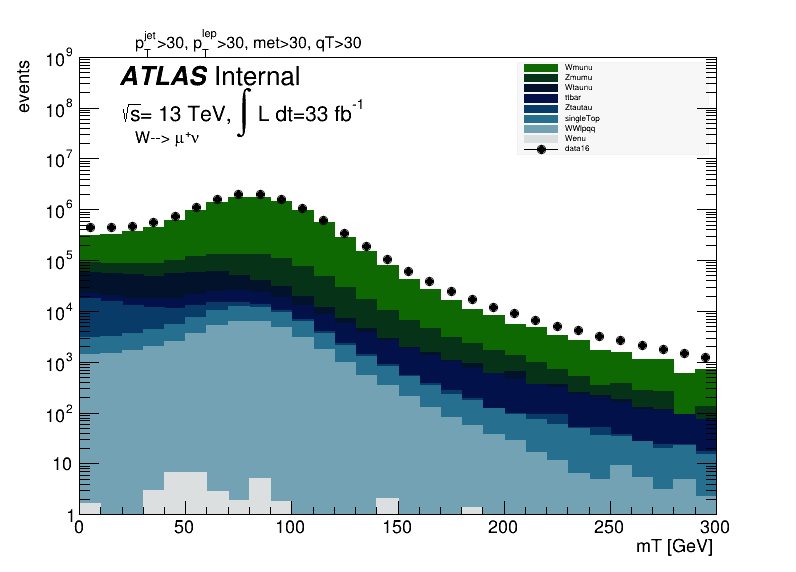

In [6]:


save_dir = "/eos/home-y/yabulait/wjets/plots/pdf/{0}/{1}/tight_selection/mu_plus/".format("dataVSmc",grid_date)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
            
fig = pyrootUtil.histplot("mT",size=[800, 600])
canv_qt = plot_samples_stack(h_mT_mc16_grouped_by_processes, log='y', x_label="mT [GeV]", y_label="events")
canv_qt.cd()

h_mT_data16_grouped_by_processes["data16"].SetMarkerStyle(20)
h_mT_data16_grouped_by_processes["data16"].SetMarkerColor(1)
fig.plot(h_mT_data16_grouped_by_processes["data16"],
                ["data16"], option="same p0",
                color=[1])
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "W--> #mu^{+}#nu",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack, "p_{T}^{jet}>30, p_{T}^{lep}>30, met>30, qT>30, b-veto",tsize=0.03)
canv_qt.Print("%s/mT.pdf"%(save_dir))

In [7]:
h_mT_mc16_grouped_by_processes["Wmunu"]

<ROOT.TH1D object ("mt") at 0x55871080>

In [8]:
h_total = h_mT_mc16_grouped_by_processes["Wmunu"].Clone("total")
h_ratio = h_mT_data16_grouped_by_processes["data16"].Clone()
h_ratio.Divide(h_total)

True

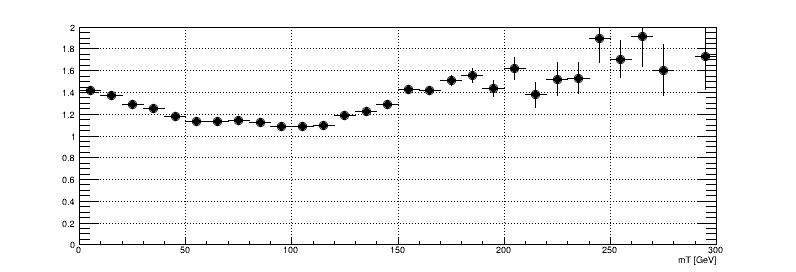

In [9]:
cRatio = ROOT.TCanvas("cRatio", "", 800,300)
cRatio.cd()
h_ratio.Draw("p0")
h_ratio.GetYaxis().SetRangeUser(0,2)
h_ratio.GetXaxis().SetTitle("mT [GeV]")
cRatio.SetGrid()
cRatio.Draw()
cRatio.Print("%s/mT_ratio.pdf"%(save_dir))

In [10]:
h_data = h_mT_data16_grouped_by_processes["data16"].Clone()


In [11]:
print("data:", h_data.Integral(6,30))
print("MC:", h_total.Integral(6,30))
print("data/MC: ", h_data.Integral(6,30)/h_total.Integral(6,30))

data: 10614811.0
MC: 9400693.632669024
data/MC:  1.129151891846758


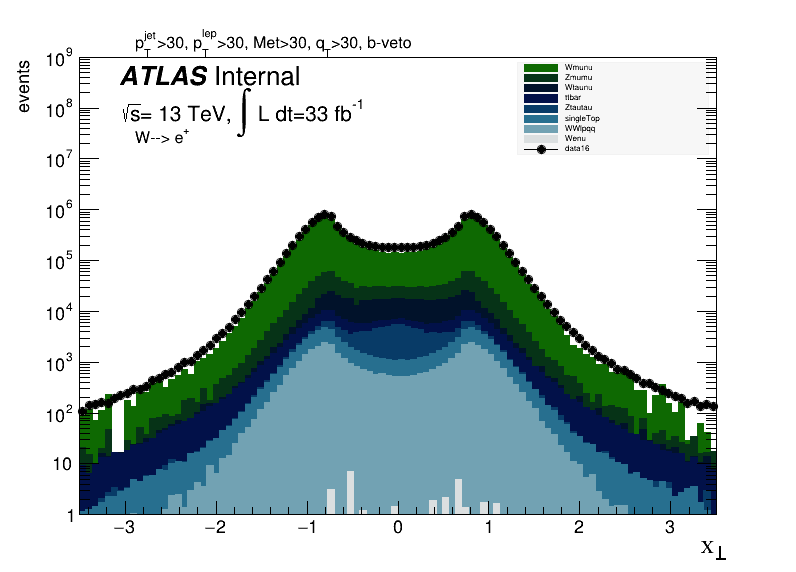

In [12]:
#styles.ATLAS_style(ROOT.gStyle)
fig = pyrootUtil.histplot("Xperp",size=[800, 600])
canv_xperp = plot_samples_stack(h_Xprep_mc16_grouped_by_processes, log='y', x_label="#Chi_{#perp}", y_label="events",
                                Draw_option="HIST SAME PFC PLC PMC Y-")
canv_xperp.cd()

h_Xprep_data16_grouped_by_processes["data16"].SetMarkerStyle(20)
h_Xprep_data16_grouped_by_processes["data16"].SetMarkerColor(1)
fig.plot(h_Xprep_data16_grouped_by_processes["data16"],
                ["data16"], option="same p0",
                color=[1])

draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "W--> e^{+}",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack,
              "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>30, q_{T}>30, b-veto",
              tsize=0.03)
canv_xperp.Print("%s/stack_xperp_NOmT.pdf"%(save_dir))

In [13]:
h_Xperp_data = h_Xprep_data16_grouped_by_processes["data16"].Clone()
h_total = h_Xprep_mc16_grouped_by_processes["Wmunu"].Clone("total")
h_ratio = h_Xprep_data16_grouped_by_processes["data16"].Clone()
h_ratio.Divide(h_total)

True

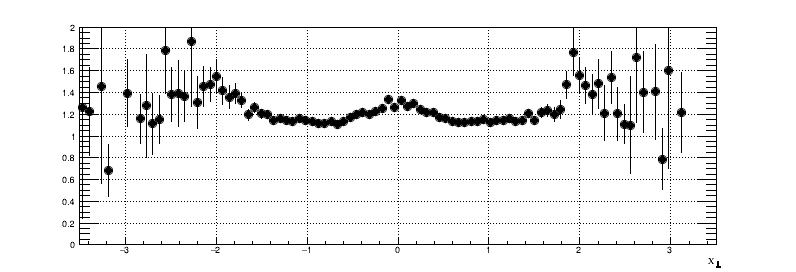

In [14]:
cRatio_Xperp = ROOT.TCanvas("cRatio_Xperp", "", 800,300)
cRatio_Xperp.cd()
h_ratio.GetYaxis().SetRangeUser(0,2)
h_ratio.GetXaxis().SetTitle("#Chi_{#perp}")
h_ratio.Draw("p0")
cRatio_Xperp.Draw()
cRatio_Xperp.SetGrid()
cRatio_Xperp.Print("%s/Xperp_ratio.pdf"%(save_dir))